# Ionization and Recombination Rates

In [92]:
import os
os.environ['XUVTOP'] = '/Users/willbarnes/ssw/packages/chianti/dbase/'

import numpy as np
from scipy.interpolate import splev,splrep,interp1d
import astropy.units as u
import astropy.constants as const
import astropy.table
import matplotlib.pyplot as plt
import matplotlib.colors
import mpld3
import fiasco
import fiasco.io
import ChiantiPy.tools as ch_tools
import ChiantiPy.core as ch
import periodictable
import hissw

%matplotlib inline
#mpld3.enable_notebook()

## Theory: Ionization Rates

### Direct Ionization

This gives the Burgess-Tully scaled cross-sections as a function of the scaled energy. See Dere (2007) for a description of this scaling. It is easy enough to descale these.

To actually calculate the direct ionization rate, the cross-section is integrated over a Maxwellian electron distribution using 12-point Gauss-Laguerre quadrature. The Maxwellian distribution is given by,

$$
f_M(E) = 2\left(\frac{E}{\pi}\right)^{1/2}(k_BT)^{-3/2}\exp\left({-\frac{E}{k_BT}}\right)
$$

So the direct ionization rate should be given by,

$$
\begin{eqnarray}
\alpha_{\mathrm{DI}} &=& \int_0^{\infty}\mathrm{d}E\,\sqrt{\frac{2E}{m_e}}f_M(E)\sigma(E) \\
&=& \int_0^{\infty}\mathrm{d}E\,\sqrt{\frac{2E}{m_e}}2\left(\frac{E}{\pi}\right)^{1/2}(k_BT)^{-3/2}\exp\left({-\frac{E}{k_BT}}\right)\sigma(E) \\
&=& \sqrt{\frac{8}{\pi m_e}}(k_BT)^{-3/2}\int_0^{\infty}\mathrm{d}E\,E\sigma(E)\exp\left({-\frac{E}{k_BT}}\right)
\end{eqnarray}
$$

Now, we want to evaluate the cross-section at $E+I$, where $I$ is the ionization potential,

$$
\begin{eqnarray}
\alpha_{\mathrm{DI}} &=& \sqrt{\frac{8}{\pi m_e}}(k_BT)^{-3/2}\int_0^{\infty}\mathrm{d}(E+I)\,(E+I)\sigma(E+I)\exp\left({-\frac{(E+I)}{k_BT}}\right) \\
&=& \sqrt{\frac{8}{\pi m_e}}(k_BT)^{-3/2}\exp\left({-\frac{I}{k_BT}}\right)\int_0^{\infty}\mathrm{d}E\,(E+I)\sigma(E+I)\exp\left({-\frac{E}{k_BT}}\right) \\
&=& \sqrt{\frac{8}{\pi m_e}}(k_BT)^{-3/2}\exp\left({-\frac{I}{k_BT}}\right)\left(\int_0^{\infty}\mathrm{d}E\,E\sigma(E+I)\exp\left({-\frac{E}{k_BT}}\right) + I\int_0^{\infty}\mathrm{d}E\,\sigma(E+I)\exp\left({-\frac{E}{k_BT}}\right)\right)
\end{eqnarray}
$$

Next, make a change of variables $x=E/k_BT$ and define for convenience $\xi=\sqrt{8/\pi m_e}$, $\beta=k_BT$, $x_0=I/k_BT$,

$$
\begin{eqnarray}
\alpha_{\mathrm{DI}} &=& \xi\beta^{-3/2}e^{-x_0}\left(\int\mathrm{d}x\,\beta^2x\sigma(\beta x + I)e^{-x} + I\int\mathrm{d}x\,\beta\sigma(\beta x + I)e^{-x}\right) \\
&=& \xi\beta^{1/2}e^{-x_0}\left(\int\mathrm{d}x\,x\sigma(\beta x + I)e^{-x} + x_0\int\mathrm{d}x\,\sigma(\beta x + I)e^{-x}\right)
\end{eqnarray}
$$

Gauss-Laguerre quadrature can be used to evaluate integrals of this form such that,

$$
\int_0^{\infty}\mathrm{d}x\,e^{-x}f(x)\approx\sum^n_{i=1}w_if(x_i)
$$

so our above expression becomes,

$$
\begin{eqnarray}
\alpha_{DI} &=& \xi\beta^{1/2}e^{-x_0}\left(\sum_iw_ix_i\sigma(\beta x_i + I) + x_0\sum_iw_i\sigma(\beta x_i+I)\right)
&=& \xi\beta^{1/2}e^{-x_0}\sum_iw_i\sigma(\beta x_i + I)(x_i + x_0)
\end{eqnarray}
$$

So for the direct ionization, we'll need two functions: one to calculate the cross-section and one to calculate the actual ionization rate.

### Excitation Autoionization
The excitation autoionization rate is given by the same expression as the collisional excitation rates, for a given excitation $ij$,

$$
\alpha_{ea,ij} = \int\mathrm{d}E\,Q_{ea,ij}vf(E) \approx \frac{h^2}{(2m_e)^{3/2}(k_BT)^{1/2}}\frac{\Upsilon_{ea,ij}}{\omega_i}\exp\left(\frac{-\Delta E}{k_BT}\right)
$$

where $\Upsilon_{ea}$ are the effective collision strengths for excitation autoionization. A full derivation of this expression can be found section 4.2.1 of Philips et al. (2008). These are descaled from a Burgess-Tully scaling. The total excitation autoionization rate is then summed over all relevant transitions,

$$
\alpha_{ea} = \sum_{ij}\alpha_{ea,ij}
$$

## Theory: Recombination Rates
There are two types of recombination that we consider: dielectronic recombination and radiative recombination. We'll address the expressions needed to get both and then 

### Radiative Recombination

### Dielectronic Recombination

## A New Ion Object

In [ ]:
class Ion(fiasco.IonBase):
    
    @u.quantity_input(temperature=u.K)
    def __init__(self,ion_name,temperature,*args,**kwargs):
        self.temperature = temperature
        super().__init__(ion_name,*args,**kwargs)
        self.Z = periodictable.__dict__[self.element.capitalize()].number
        # Use selected datasets
        self._ip = super().ip[kwargs.get('ip_filename','chianti')]*const.h.cgs*const.c.cgs
    
    @property
    def ip(self):
        return self._ip
    
    @ip.setter
    def ip(self,value):
        self._ip = value
        
    @staticmethod
    def burgess_tully_descale(x,y,energy_ratio,c,scaling_type):
        """
        Convert scaled Burgess-Tully parameters to physical quantities 
        """
        nots = splrep(x, y, s=0)
        if scaling_type == 1:
            x_new = 1.0 - np.log(c)/np.log(energy_ratio + c)
            upsilon = splev(x_new, nots, der=0)*np.log(energy_ratio + np.e)
        elif scaling_type == 2:
            x_new = energy_ratio/(energy_ratio + c)
            upsilon = splev(x_new, nots, der=0)
        elif scaling_type == 3:
            x_new = energy_ratio/(energy_ratio + c)
            upsilon = splev(x_new, nots, der=0)/(energy_ratio + 1.0)
        elif scaling_type == 4:
            x_new = 1.0 - np.log(c)/np.log(energy_ratio + c)
            upsilon = splev(x_new, nots, der=0)*np.log(energy_ratio + c)
        elif scaling_type == 5:
            # dielectronic
            x_new = energy_ratio/(energy_ratio + c)
            upsilon = splev(x_new,nots,der=0)/energy_ratio
        elif scaling_type == 6:
            # protons
            x_new = energy_ratio/(energy_ratio + c)
            upsilon = 10**splev(x_new, nots, der=0)
        else:
            raise ValueError('Unrecognized BT92 scaling option.')

        return upsilon
    
    def direct_ionization_rate(self):
        """
        Calculate direct ionization rate in cm3/s
        
        Needs an equation reference or explanation
        """
        xgl,wgl = np.polynomial.laguerre.laggauss(12)
        kBT = const.k_B.cgs*self.temperature
        energy = np.outer(xgl,kBT)*kBT.unit + self.ip
        cross_section = self.direct_ionization_cross_section(energy)
        term1 = np.sqrt(8./np.pi/const.m_e.cgs)*np.sqrt(kBT)*np.exp(-self.ip/kBT)
        term2 = ((wgl*xgl)[:,np.newaxis]*cross_section).sum(axis=0)
        term3 = (wgl[:,np.newaxis]*cross_section).sum(axis=0)*self.ip/kBT
        
        return term1*(term2 + term3)
    
    def direct_ionization_cross_section(self,energy):
        """
        Calculate direct ionization cross-section
        """
        is_hydrogenic =  (self.Z - self.stage + 1 == 1) and (self.Z >= 6)
        is_he_like = (self.Z - self.stage + 1 == 2) and (self.Z >= 10)
        
        if is_hydrogenic or is_he_like:
            # Fontes cross sections
            U = energy/self.ip
            A = 1.13
            if is_hydrogenic:
                B = 1
            else:
                B = 2
            if self.Z < 20:
                F = 1
            else:
                F = (140 + (self.Z/20)**3.2)/141
            if self.Z >= 16:
                c = -0.28394
                d = 1.95270
                C = 0.20594
                if self.Z > 20:
                    C += ((self.Z - 20)/50.5)**1.11
                D = 3.70590
            else:
                c = -0.80414
                d = 2.32431
                C = 0.14424
                D = 3.82652
            Qrp = 1./U*(A*np.log(U) + D*(1. - 1./U)**2 + C*U*(1. - 1./U)**4 + (c/U + d/U**2)*(1. - 1./U))
            
            return B*(np.pi*const.a0.cgs**2)*F*Qrp/(self.ip.to(u.Ry).value**2)
                
        else:
            # Cross-sections from diparams file
            cross_section_total = np.zeros(energy.shape)
            for ip,bt_c,bt_e,bt_cross_section in zip(self.diparams['ip'],self.diparams['bt_c'],self.diparams['bt_e'],
                                                     self.diparams['bt_cross_section']):
                U = energy/(ip.to(u.erg))
                scaled_energy = 1. - np.log(bt_c)/np.log(U - 1. + bt_c)
                f_interp = interp1d(bt_e.value,bt_cross_section.value,
                                    kind='cubic',fill_value='extrapolate')
                scaled_cross_section = f_interp(scaled_energy.value)*bt_cross_section.unit
                # Only nonzero at energies above the ionization potential
                scaled_cross_section *= (U.value > 1.)
                cross_section = scaled_cross_section*(np.log(U) + 1.)/U/(ip**2)
                if not hasattr(cross_section_total,'unit'):
                    cross_section_total = cross_section_total*cross_section.unit
                cross_section_total += cross_section
                
            return cross_section_total
            
    def excitation_autoionization_rate(self):
        """
        Calculate ionization rate due to excitation autoionization
        """
        if self.easplups is None:
            return np.zeros(self.temperature.shape)*u.cm**3/u.s
        # Collision constant
        c = (const.h.cgs**2)/((2.*np.pi*const.m_e.cgs)**(1.5)*np.sqrt(const.k_B.cgs))
        kBTE = u.Quantity([(const.k_B.cgs*self.temperature)/(de.to(u.erg)) for de in self.easplups['delta_energy']])
        # Descale upsilon
        shape = self.easplups['bt_upsilon'].shape
        xs = np.tile(np.linspace(0,1,shape[1]),shape[0]).reshape(shape)
        args = [xs,self.easplups['bt_upsilon'].value,kBTE.value,self.easplups['bt_c'].value,self.easplups['bt_type']]
        upsilon = u.Quantity(list(map(self.burgess_tully_descale,*args)))
        # Rate coefficient
        rate = c*upsilon*np.exp(-1/kBTE)/np.sqrt(self.temperature[np.newaxis,:])
        
        return rate.sum(axis=0)
    
    def ionization_rate(self):
        return self.direct_ionization_rate() + self.excitation_autoionization_rate()
    
    def radiative_recombination_rate(self):
        if self.rrparams is None:
            return np.zeros(self.temperature.shape)*u.cm**3/u.s
        if self.rrparams['fit_type'][0] == 1 or self.rrparams['fit_type'][0] == 2:
            A = self.rrparams['A_fit']
            B = self.rrparams['B_fit']
            if self.rrparams['fit_type'] == 2:
                B = B + self.rrparams['C_fit']*np.exp(-self.rrparams['T2_fit']/self.temperature)
            T0 = self.rrparams['T0_fit']
            T1 = self.rrparams['T1_fit']
            
            return A/(np.sqrt(self.temperature/T0)*(1 + np.sqrt(self.temperature/T0))**(1. - B)
                      *(1. + np.sqrt(self.temperature/T1))**(1. + B))
        elif self.rrparams['fit_type'][0] == 3:
            return self.rrparams['A_fit']*(self.temperature/(1e4*u.K))**(-self.rrparams['eta_fit'])
        else:
            raise ValueError('Unrecognized fit type {}'.format(self.rrparams['fit_type']))
    
    def dielectronic_recombination_rate(self):
        if self.drparams is None:
            return np.zeros(self.temperature.shape)*u.cm**3/u.s
        if self.drparams['fit_type'][0] == 1:
            E_over_T = np.outer(self.drparams['E_fit'],1./self.temperature)*(self.drparams['E_fit'].unit/self.temperature.unit)
            return self.temperature**(-1.5)*(self.drparams['c_fit'][:,np.newaxis]*np.exp(-E_over_T)).sum(axis=0)
        elif self.drparams['fit_type'][0] == 2:
            A = self.drparams['A_fit']
            B = self.drparams['B_fit']
            T0 = self.drparams['T0_fit']
            T1 = self.drparams['T1_fit']
            return A*self.temperature**(-1.5)*np.exp(-T0/self.temperature)*(1. + B*np.exp(-T1/self.temperature))
        else:
            raise ValueError('Unrecognized fit type {}'.format(self.drparams['fit_type']))
    
    def recombination_rate(self):
        return self.radiative_recombination_rate() + self.dielectronic_recombination_rate()

## Testing

In [176]:
temperature = np.logspace(5,8,50)*u.K

Create ChiantiPy and Fiasco ion objects

In [ ]:
chp_ion = ch.ion('fe_2',temperature=temperature.value)

In [ ]:
chp_ion.Ip

In [ ]:
fiasco_ion = fiasco.Ion('fe_11',temperature)

In [ ]:
fiasco_ion.scups

### Ionization

Test excitation autoionization rate

In [ ]:
chp_ion.eaRate()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(temperature,fiasco_ion.excitation_autoionization_rate())
plt.plot(temperature,chp_ion.EaRate['rate'],marker='o',ls='',markevery=5)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-20,1e-8])

Test direct ionization cross-section

In [ ]:
xgl,wgl = np.polynomial.laguerre.laggauss(12)
energy = fiasco_ion.ip + np.outer(const.k_B.cgs*fiasco_ion.temperature,xgl)*(const.k_B.cgs.unit*fiasco_ion.temperature.unit)

In [ ]:
chp_cross_section = np.empty(energy.shape)
fiasco_cross_section = np.empty(energy.shape)
for i in range(energy.shape[1]):
    tmp = fiasco_ion.direct_ionization_cross_section(energy[:,i])
    fiasco_cross_section[:,i] = tmp
    chp_ion.diCross(energy[:,i].to(u.eV).value)
    chp_cross_section[:,i] = chp_ion.DiCross['cross']

In [ ]:
plt.plot(fiasco_ion.temperature,fiasco_cross_section)
plt.plot(chp_ion.Temperature,chp_cross_section,marker='o',ls='',markevery=5)
plt.xscale('log')
plt.yscale('log')

Test direct ionization rate

In [ ]:
chp_ion.diRate()

In [ ]:
plt.plot(fiasco_ion.temperature,fiasco_ion.direct_ionization_rate())
plt.plot(chp_ion.Temperature,chp_ion.DiRate['rate'],'o',markevery=5)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-12,1e-8])

### Recombination

In [ ]:
chp_ion.recombRate()

In [ ]:
plt.plot(fiasco_ion.temperature,fiasco_ion.recombination_rate())
plt.plot(fiasco_ion.temperature,fiasco_ion.radiative_recombination_rate())
plt.plot(fiasco_ion.temperature,fiasco_ion.dielectronic_recombination_rate())
plt.plot(chp_ion.Temperature,chp_ion.RecombRate['rate'],'o',markevery=5)
plt.plot(chp_ion.Temperature,chp_ion.RrRate['rate'],'o',markevery=5)
plt.plot(chp_ion.Temperature,chp_ion.DrRate['rate'],'o',markevery=5)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-12,5e-9])

In [ ]:
foo = ch.ion('ca_7',temperature=temperature.value)
foo.recombRate()

In [ ]:
plt.plot(temperature,
         fiasco.Ion('ca_7',temperature).recombination_rate(),'k')
plt.plot(temperature,
         fiasco.Ion('ca_7',temperature).dielectronic_recombination_rate())
plt.plot(temperature,
         fiasco.Ion('ca_7',temperature).radiative_recombination_rate())
plt.plot(temperature, foo.RecombRate['rate'],'ko',markevery=5)
plt.plot(temperature, foo.DrRate['rate'],'o',markevery=5)
plt.plot(temperature, foo.RrRate['rate'],'o',markevery=5)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-15,1e-9])

### Ionization Equilibrium

In [177]:
iron = fiasco.Element('Fe',temperature)

In [178]:
a_matrix = np.zeros(temperature.shape+(iron[0].Z+1,iron[0].Z+1))

In [179]:
for i in range(1,iron[0].Z):
    a_matrix[:,i,i] = -(iron[i+1].ionization_rate() + iron[i].recombination_rate()).value
    a_matrix[:,i,i-1] = iron[i].ionization_rate().value
    a_matrix[:,i,i+1] = iron[i+1].recombination_rate().value
a_matrix[:,0,0] = -iron[1].ionization_rate().value
a_matrix[:,0,1] = iron[1].recombination_rate().value
a_matrix[:,iron[0].Z,iron[0].Z] = -iron[iron[0].Z-1].recombination_rate().value
a_matrix[:,iron[0].Z,iron[0].Z-1] = iron[iron[0].Z-1].ionization_rate().value

In [180]:
uu,ss,vv = np.linalg.svd(a_matrix)

In [181]:
yy = vv[:,-1,:]
yy = np.where(yy<0,0,yy)
yy /= np.sum(yy,axis=1)[:,np.newaxis]

/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [185]:
yy_manual = np.zeros(temperature.shape+(iron[0].Z+1,))
yy_manual[:,1] = 0.5
for i in range(iron[0].Z+1):
    if i<1:
        yy_manual[:,i] = iron[i].recombination_rate()/iron[i].ionization_rate()*yy_manual[:,1]
    elif i>1:
        yy_manual[:,i] = iron[i-1].recombination_rate()/iron[i-1].ionization_rate()*yy_manual[:,i-1]
    else:
        continue
yy_manual /= np.sum(yy_manual,axis=1)[:,np.newaxis]

/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)
/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


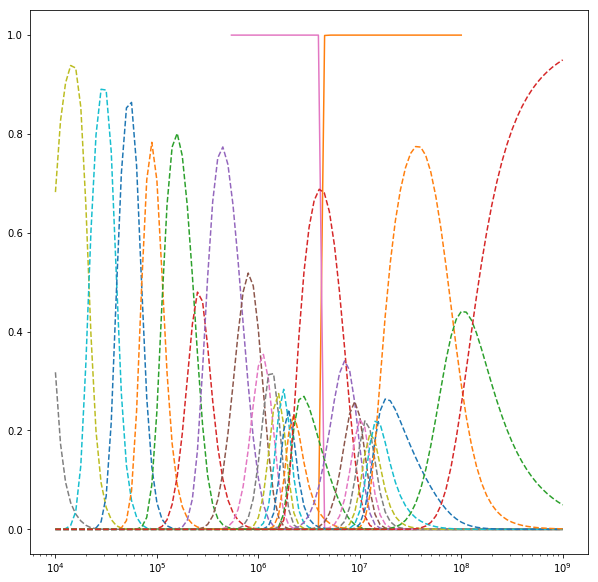

In [186]:
plt.figure(figsize=(10,10))
plt.plot(temperature,yy_manual)
for ion_name in iron.ions:
    tmp = fiasco.IonBase(ion_name)
    plt.plot(tmp.ioneq['chianti']['temperature'],tmp.ioneq['chianti']['ionization_fraction'],ls='--')
plt.xscale('log')

## Comparisons to IDL Results

In [ ]:
runner = hissw.ScriptMaker(ssw_packages=['chianti'],ssw_paths=['chianti'])

In [ ]:
script = """
energy = {{energy}}
temperature = {{temperature}}
cross = ioniz_cross('fe_11',energy)
rate = ioniz_rate('fe_11',temperature)
"""

In [ ]:
res = runner.run([(script,{'energy':energy[:,0].to(u.eV).value.tolist(),
                           'temperature':temperature.value.tolist()})],
                 save_vars=['cross','energy','rate'],verbose=True)

In [ ]:
chp_ion.eaCross(energy=energy[:,0].to(u.eV).value)

In [ ]:
plt.plot(energy[:,0].to(u.eV),fiasco_ion.direct_ionization_cross_section(energy[:,0]))
plt.plot(res['energy'],res['cross'],'--')
plt.plot((energy[:,0].to(u.eV),chp_cross_section[:,0]
         #+chp_ion.EaCross['cross']
         ),
         'o',markevery=2)
#plt.plot(energy[:,0].to(u.eV),chp_ion.EaCross['cross'],'>')
plt.plot(energy[:,0].to(u.eV),chp_cross_section[:,0],'s',markevery=5)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-20,2e-18])

In [ ]:
chp_ion.ionizRate()

In [ ]:
plt.plot(temperature,fiasco_ion.ionization_rate())
plt.plot(chp_ion.Temperature,chp_ion.IonizRate['rate'],'o',markevery=7)
#plt.plot(temperature,res['rate'],'^',markevery=5)
plt.ylim([1e-12,1e-8])
plt.xscale('log')
plt.yscale('log')

## Sandbox